In [32]:
import pandas as pd
import numpy as np
import sklearn
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost.sklearn import XGBRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, Ridge
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, StratifiedKFold, train_test_split, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error as mse

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

## Load data

In [2]:
df = pd.read_csv('../data/fairlymade_products_impacts.csv')

## Drop product_types with too few items

In [3]:
threshold = 20
n_instances_before_dropping = len(df)

all_product_types = df['product_type'].unique()

product_type_count = df['product_type'].value_counts()
product_types_to_drop = product_type_count[product_type_count < threshold].index

df = df[~df['product_type'].isin(product_types_to_drop)]

print(f"Dropping {len(product_types_to_drop)} out of {len(product_type_count)} product_types because they have less then {threshold} items")
print(f"Percentage of instances dropped {round(100*(n_instances_before_dropping-len(df))/len(df), 2)}%")

Dropping 4 out of 34 product_types because they have less then 20 items
Percentage of instances dropped 0.38%


## Split the data

In [4]:
drop_columns = ['study_id', 'resource_use_fossils']
target = ['climate_change']
drop_columns.extend(target)

train, test = train_test_split(df, test_size=0.3, stratify=df['product_type'], random_state=0)
test, val = train_test_split(test, test_size=0.5, stratify=test['product_type'], random_state=0)

X_train, y_train = train.drop(columns=drop_columns), train[target].values.ravel()
X_val, y_val = val.drop(columns=drop_columns), val[target].values.ravel()
X_test, y_test = test.drop(columns=drop_columns), test[target].values.ravel()

In [5]:
print(f"X_train: {len(X_train)}, y_train: {len(y_train)}")
print(f"X_val: {len(X_val)}, y_val: {len(y_val)}")
print(f"X_test: {len(X_test)}, y_test: {len(y_test)}")

X_train: 6219, y_train: 6219
X_val: 1333, y_val: 1333
X_test: 1333, y_test: 1333


## Preprocessing pipeline

In [6]:
def convert_col_to_string(df, cols=['product_type', 'composition', 'raw_material_country', 
                                'weaving_country', 'dyeing_country', 'manufacturing_country']):
    for col in cols:
        df[col] = df[col].astype(str)
    return df

In [7]:
def generate_preprocessing_transformer():
    preprocessing_transformer = make_column_transformer(
        (OneHotEncoder(handle_unknown="infrequent_if_exist", min_frequency=10, sparse_output=False), ['product_type']),
        (OneHotEncoder(drop='if_binary'), ['plane_in_transports']),
        (CountVectorizer(strip_accents='ascii'), 'raw_material_country'),
        (CountVectorizer(strip_accents='ascii'), 'weaving_country'),
        (CountVectorizer(strip_accents='ascii'), 'dyeing_country'),
        (CountVectorizer(strip_accents='ascii'), 'manufacturing_country'),
        (CountVectorizer(strip_accents='ascii'), 'composition'),
        remainder='drop'
    )

    return preprocessing_transformer

In [8]:
preprocessing_pipeline =  Pipeline([
        ('preprocessing', generate_preprocessing_transformer()),
    ])

In [9]:
X_train = convert_col_to_string(X_train)
X_val = convert_col_to_string(X_val)
X_test = convert_col_to_string(X_test)

In [10]:
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)

In [11]:
X_train_preprocessed

<6219x283 sparse matrix of type '<class 'numpy.float64'>'
	with 48610 stored elements in Compressed Sparse Row format>

In [12]:
models_list = {
               'Ridge': Ridge(),
               'DecisionTree Regressor': DecisionTreeRegressor(),
               'Random Forest': RandomForestRegressor(), 
               'SVR': SVR(), 
               'XGBRegressor': XGBRegressor(),
               'Lasso': Lasso(),
               'KernelRidge': KernelRidge(),
               'ElasticNet': ElasticNet(),
               'GradientBoostingRegressor': GradientBoostingRegressor()
              }

scoring = {'max_error': 'max_error', 'neg_mean_squared_error': 'neg_mean_squared_error', 'r2':'r2'}
columns = ['Model', 'Median fit time', 'Mean max error', 'Std max error', 'RMSE', 'Std RMSE', 'Mean r2', 'Std r2']

folds = KFold(n_splits=5, shuffle=True, random_state=0)

In [13]:
X = X_train
y = y_train

model_perf_matrix = []
predictions = pd.DataFrame()
for model_name, model in tqdm(models_list.items()):
    pipeline = Pipeline([ 
        ('preprocessing', generate_preprocessing_transformer()),
        ('model', model)
    ])

    cv_score = cross_validate(pipeline, X, y, cv=folds, scoring=scoring, verbose=0, error_score="raise");
    model_perf_matrix.append([model_name, round(cv_score['fit_time'].mean(),3),
                                          round(cv_score['test_max_error'].mean(),4), round(cv_score['test_max_error'].std(),4),
                                          round(np.sqrt(-cv_score['test_neg_mean_squared_error']).mean(),4), round(np.sqrt(-cv_score['test_neg_mean_squared_error']).std(),4),
                                          round(cv_score['test_r2'].mean(),4), round(cv_score['test_r2'].std(),4)])
    
    pipeline.fit(X, y)
    predictions[model_name] = pipeline.predict(X_val).T
    
df_model_perf = pd.DataFrame(model_perf_matrix, columns=columns)
df_model_perf

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:08<00:00,  7.66s/it]


,Model,Median fit time,Mean max error,Std max error,Mean error,Std mean error,Mean r2,Std r2
0,Ridge,0.085,-295.7801,63.0386,24.0353,1.8936,0.5449,0.0252
1,DecisionTree Regressor,0.161,-281.6052,83.1512,19.4845,1.0573,0.6978,0.0411
2,Random Forest,6.965,-263.3894,101.1077,18.2329,1.4254,0.7368,0.0305
3,SVR,1.360,-384.3536,69.3971,29.5060,2.3774,0.3148,0.0280
4,XGBRegressor,0.136,-259.8580,89.5692,18.2589,1.4465,0.7350,0.0389
5,Lasso,0.079,-346.3192,69.1519,27.2046,2.1204,0.4170,0.0300
6,KernelRidge,1.101,-296.1295,62.8524,24.0459,1.8976,0.5445,0.0252
7,ElasticNet,0.079,-389.7138,67.4950,32.1388,2.2769,0.1864,0.0167
8,GradientBoostingRegressor,0.252,-244.9634,99.4328,19.7466,1.3512,0.6927,0.0101


In [14]:
predictions['label'] = y_val
predictions

,Ridge,DecisionTree Regressor,Random Forest,SVR,XGBRegressor,Lasso,KernelRidge,ElasticNet,GradientBoostingRegressor,label
0,13.470959,12.472909,13.774364,15.824836,12.175664,5.956887,14.177837,9.103895,19.735030,12.178119
1,62.748462,78.184941,79.174173,32.861656,77.888763,77.128668,62.633539,35.619234,53.012212,91.948182
2,0.410560,6.984949,6.889602,6.339246,5.273140,13.900364,0.292950,17.611345,7.428152,6.815810
3,26.157813,15.798639,15.980910,17.238265,19.032478,13.900364,25.951896,17.926515,20.231491,14.716049
4,16.982425,2.528695,6.482254,10.190521,7.796122,17.872102,16.286746,23.430663,12.391543,5.331121
...,...,...,...,...,...,...,...,...,...,...
1328,3.912336,4.345440,4.694973,9.069501,5.083318,17.872102,3.707318,22.858529,7.443683,4.341375
1329,3.735005,2.677243,3.205756,9.046104,6.757689,12.388404,2.779848,15.350309,6.923488,2.523200
1330,9.756810,10.816239,10.903150,11.612676,11.730863,13.900364,9.983479,19.342273,12.160687,11.788730
1331,33.594122,32.264075,32.135844,27.846688,28.045702,21.060438,33.367570,27.492851,24.968007,30.412119


In [39]:
for col in predictions.columns[0:-1]:
    print(f"val RMSE of {col}: {round(np.sqrt(mse(y_true=y_val, y_pred=predictions[col])), 6)}")

val RMSE of Ridge: 19.776891
val RMSE of DecisionTree Regressor: 21.62732
val RMSE of Random Forest: 17.377703
val RMSE of SVR: 24.408463
val RMSE of XGBRegressor: 18.022097
val RMSE of Lasso: 22.489828
val RMSE of KernelRidge: 19.807566
val RMSE of ElasticNet: 27.727013
val RMSE of GradientBoostingRegressor: 17.905583


### Hyperparameter optimisation

In [66]:
params = [{
            'type': 'XGBRegressor',
            'max_depth': scope.int(hp.quniform('XGBRegressor_max_depth', 3, 15, 1)),
            'n_estimators': scope.int(hp.quniform('XGBRegressor_n_estimators', 10, 500, 10)),
            'colsample_bytree': hp.quniform('XGBRegressor_colsample_bytree', 0.2, 1.0, 0.05),
            'min_child_weight': scope.int(hp.quniform('XGBRegressor_min_child_weight', 0, 10, 1)),
            'subsample': hp.quniform('XGBRegressor_subsample', 0.2, 1.0, 0.05),
            'learning_rate': hp.quniform('XGBRegressor_learning_rate', 0.01, 0.4, 0.01),
            'gamma': hp.uniform('XGBRegressor_gamma', 0, 1),
            'reg_alpha': hp.quniform('XGBRegressor_reg_alpha', 0, 1, 0.1),
            'reg_lambda': hp.quniform('XGBRegressor_reg_lambda', 0, 1, 0.1),
            'objective': 'reg:squaredlogerror',
            'eval_metric': 'rmse',
        }]

In [67]:
def get_model_from_str(model_name, params):
    if model_name == 'XGBRegressor':
        return XGBRegressor(**params) 

In [68]:
def objective(params):
    scoring = {'max_error': 'max_error', 'neg_mean_squared_error': 'neg_mean_squared_error', 'r2':'r2'}
    folds = KFold(n_splits=5, shuffle=True, random_state=0)

    regressor = params['type']
    del params['type']
    
    model = get_model_from_str(regressor, params)

    pipeline = Pipeline([ 
        ('preprocessing', generate_preprocessing_transformer()),
        ('model', model)
    ])

    cv_score = cross_validate(pipeline, X_train, y_train, cv=folds, scoring=scoring,
                                  verbose=0, error_score="raise", return_estimator=True)
    rmse_train = round(np.sqrt(-cv_score['test_neg_mean_squared_error']).mean(), 6)
    rmse_val = round(np.sqrt(mse(y_true=y_val, y_pred=cv_score['estimator'][0].predict(X_val))), 6)

    return {'loss': rmse_val, 'status': STATUS_OK}

In [69]:
models_preselected = ['XGBRegressor']

regressor_search_space = [h for h in params if h['type'] in models_preselected]
search_space = hp.choice('regressor', regressor_search_space)
trials = Trials()
algo = tpe.suggest
best_result = fmin(fn=objective, space=search_space, algo=algo, max_evals=500, trials=trials)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [09:16<00:00,  1.11s/trial, best loss: 19.690654]


In [70]:
best_result

{'XGBRegressor_colsample_bytree': 1.0,
 'XGBRegressor_gamma': 0.0022981080633897697,
 'XGBRegressor_learning_rate': 0.36,
 'XGBRegressor_max_depth': 11.0,
 'XGBRegressor_min_child_weight': 0.0,
 'XGBRegressor_n_estimators': 260.0,
 'XGBRegressor_reg_alpha': 0.8,
 'XGBRegressor_reg_lambda': 0.0,
 'XGBRegressor_subsample': 0.8,
 'regressor': 0}

In [63]:
model_perf_matrix = []
model_name = 'optimized_xgb'

best_pipeline = Pipeline([ 
        ('preprocessing', generate_preprocessing_transformer()),
        ('model', XGBRegressor(**best_result))
    ])

cv_score = cross_validate(pipeline, X, y, cv=folds, scoring=scoring, verbose=0, error_score="raise");
model_perf_matrix.append([model_name, round(cv_score['fit_time'].mean(),3),
                                      round(cv_score['test_max_error'].mean(),4), round(cv_score['test_max_error'].std(),4),
                                      round(np.sqrt(-cv_score['test_neg_mean_squared_error']).mean(),4), round(np.sqrt(-cv_score['test_neg_mean_squared_error']).std(),4),
                                      round(cv_score['test_r2'].mean(),4), round(cv_score['test_r2'].std(),4)])

pipeline.fit(X, y)
predictions[model_name] = pipeline.predict(X_val).T

df_model_perf = pd.DataFrame(model_perf_matrix, columns=columns)
df_model_perf

,Model,Median fit time,Mean max error,Std max error,Mean error,Std mean error,Mean r2,Std r2
0,optimized_xgb,0.258,-244.6671,99.309,19.7035,1.3958,0.6941,0.0102


In [64]:
predictions

,Ridge,DecisionTree Regressor,Random Forest,SVR,XGBRegressor,Lasso,KernelRidge,ElasticNet,GradientBoostingRegressor,label,optimized_xgb
0,13.470959,12.472909,13.774364,15.824836,12.175664,5.956887,14.177837,9.103895,19.735030,12.178119,19.735030
1,62.748462,78.184941,79.174173,32.861656,77.888763,77.128668,62.633539,35.619234,53.012212,91.948182,53.012212
2,0.410560,6.984949,6.889602,6.339246,5.273140,13.900364,0.292950,17.611345,7.428152,6.815810,7.428152
3,26.157813,15.798639,15.980910,17.238265,19.032478,13.900364,25.951896,17.926515,20.231491,14.716049,20.231491
4,16.982425,2.528695,6.482254,10.190521,7.796122,17.872102,16.286746,23.430663,12.391543,5.331121,12.391543
...,...,...,...,...,...,...,...,...,...,...,...
1328,3.912336,4.345440,4.694973,9.069501,5.083318,17.872102,3.707318,22.858529,7.443683,4.341375,7.443683
1329,3.735005,2.677243,3.205756,9.046104,6.757689,12.388404,2.779848,15.350309,6.923488,2.523200,6.923488
1330,9.756810,10.816239,10.903150,11.612676,11.730863,13.900364,9.983479,19.342273,12.160687,11.788730,12.160687
1331,33.594122,32.264075,32.135844,27.846688,28.045702,21.060438,33.367570,27.492851,24.968007,30.412119,24.968007


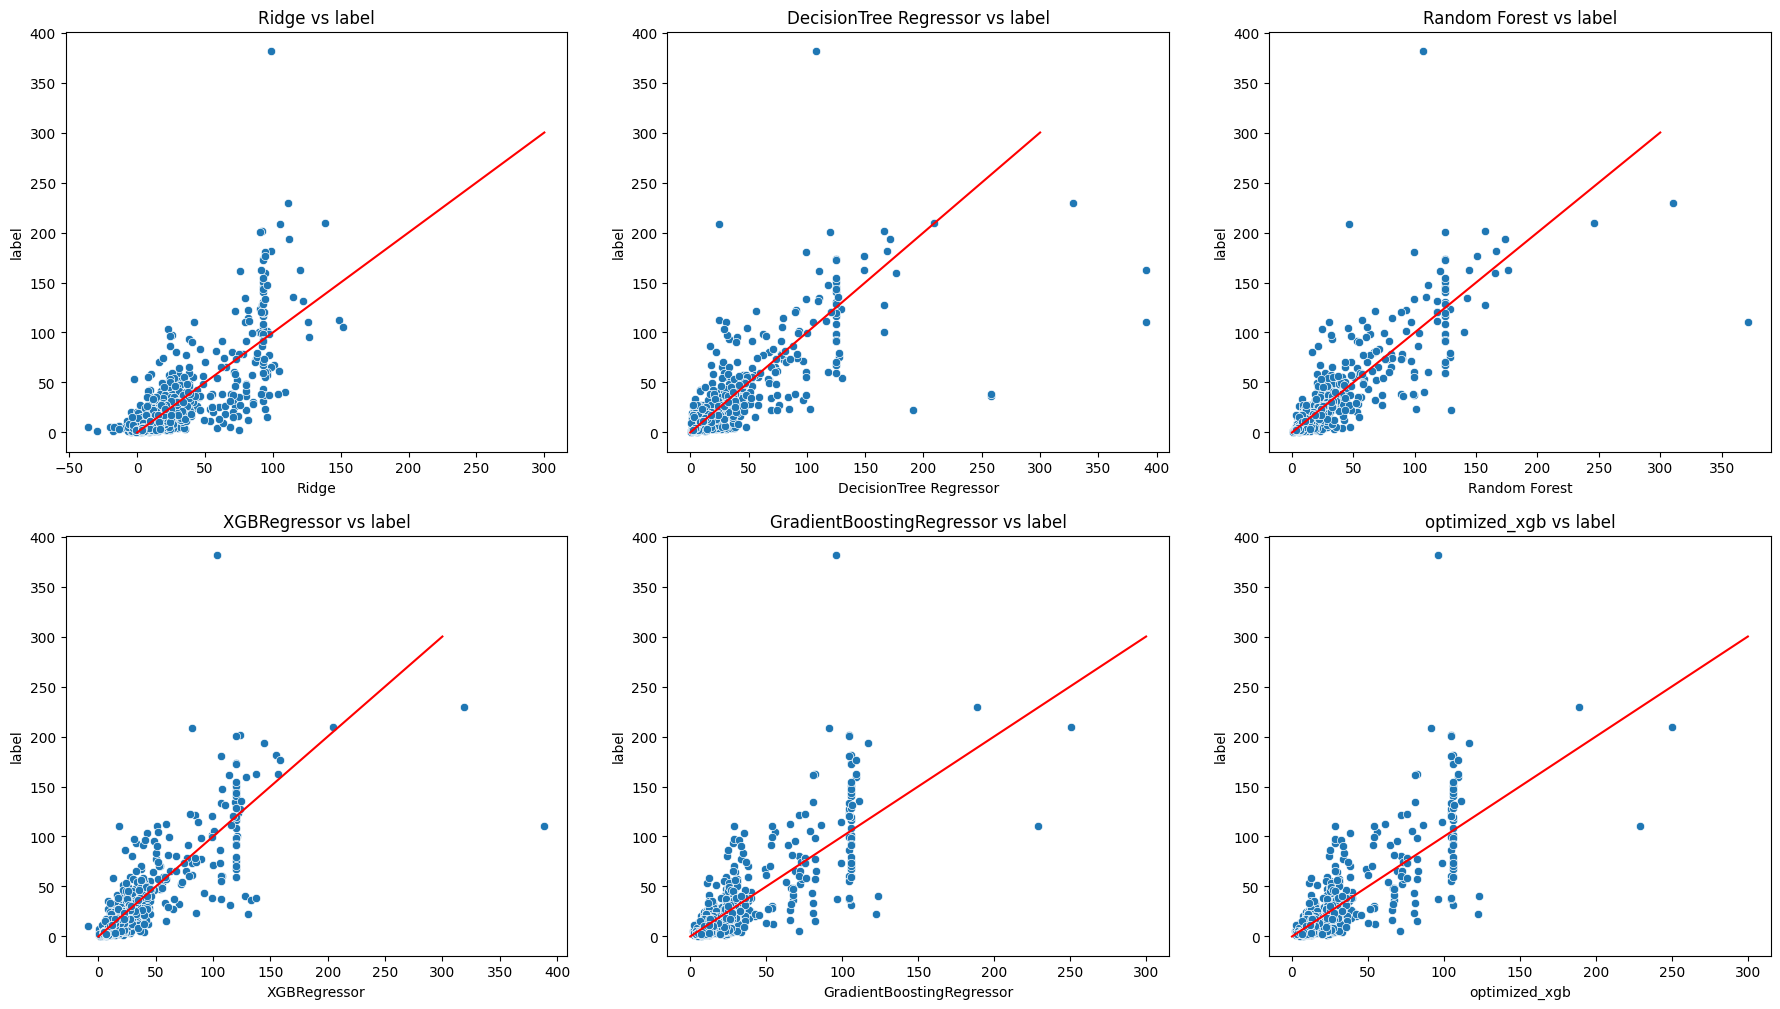

In [65]:
lim = 300

fig, ax = plt.subplots(2,3, figsize=(22,12))
sns.scatterplot(x="Ridge", y="label", data=predictions, ax=ax[0][0])
ax[0][0].set_title('Ridge vs label');
ax[0][0].plot([0, lim], [0, lim], c = "red")
sns.scatterplot(x="DecisionTree Regressor", y="label", data=predictions, ax=ax[0][1])
ax[0][1].set_title('DecisionTree Regressor vs label');
ax[0][1].plot([0, lim], [0, lim], c = "red")
sns.scatterplot(x="Random Forest", y="label", data=predictions, ax=ax[0][2])
ax[0][2].set_title('Random Forest vs label');
ax[0][2].plot([0, lim], [0, lim], c = "red")
sns.scatterplot(x="XGBRegressor", y="label", data=predictions, ax=ax[1][0])
ax[1][0].set_title('XGBRegressor vs label');
ax[1][0].plot([0, lim], [0, lim], c = "red")
sns.scatterplot(x="GradientBoostingRegressor", y="label", data=predictions, ax=ax[1][1])
ax[1][1].set_title('GradientBoostingRegressor vs label');
ax[1][1].plot([0, lim], [0, lim], c = "red")
sns.scatterplot(x="optimized_xgb", y='label', data=predictions, ax=ax[1][2])
ax[1][2].set_title('optimized_xgb vs label');
ax[1][2].plot([0, lim], [0, lim], c = "red")

In [ ]:
df_results = predictions[['XGBRegressor', 'label']]
df_results.loc[df_results['XGBRegressor'] < 1, 'XGBRegressor'] = 1
df_results['xgb_low'] = df_results['XGBRegressor'] * 0.8
df_results['xgb_high'] = df_results['XGBRegressor'] * 1.2
df_results['correct'] = (df_results['label'] > df_results['xgb_low']) & (df_results['label'] < df_results['xgb_high'])
df_results['correct'] = df_results['correct'].astype(int)
df_results.describe()

In [ ]:
df_results[df_results['label'] < df_results['label'].quantile(0.01)]

In [ ]:
df_results[df_results['label'] > df_results['label'].quantile(0.99)]